In [101]:
import tensorflow as tf


class DQN(tf.keras.models.Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.input_layer = tf.keras.layers.Input(shape=(state_size,))
        self.hidden_layers = [
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
        ]
        self.output_layer = tf.keras.layers.Dense(action_size, activation="linear")

    def call(self, inputs):
        x = self.input_layer(inputs)
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

In [102]:
from collections import deque
import numpy as np


class ReplayBuffer(object):
    def __init__(self, memory_size) -> None:
        self.buffer = deque(maxlen=memory_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def __len__(self):
        return len(self.buffer)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[i] for i in indices]

        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (
            states,
            actions,
            rewards.astype(np.float32),
            next_states,
            dones.astype(np.float32),
        )

In [103]:
num_episodes = 5000
learning_rate = 0.00005
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.9999
batch_size = 128
discount = 0.95
update_target_every = 10
buffer = ReplayBuffer(100000)

In [104]:
import gymnasium as gym

env = gym.make("CartPole-v1")
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

main_model = DQN(state_size, action_size)
target_model = DQN(action_size)
target_model.set_weights(main_model.get_weights())

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

TypeError: DQN.__init__() missing 1 required positional argument: 'action_size'

In [ ]:
def epsilon_greedy_policy(state, epsilon):
    if tf.random.uniform((1,)) < epsilon:
        return env.action_space.sample()
    return tf.argmax(main_model(state)[0]).numpy()


@tf.function
def train_step(states, actions, rewards, next_states, dones):
    next_qs = target_model(next_states)
    max_next_qs = tf.reduce_max(next_qs, axis=-1)
    target = rewards + (1.0 - dones) * discount * max_next_qs
    with tf.GradientTape() as tape:
        qs = main_model(states)
        action_masks = tf.one_hot(actions, action_size)
        qs = tf.reduce_sum(tf.multiply(qs, action_masks), axis=-1)
        loss = loss_fn(target, qs)
    grads = tape.gradient(loss, main_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, main_model.trainable_variables))
    return loss

In [ ]:
episode_rewards = []
episode_losses = []
episode_epsilons = []

for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward, done = 0, False
    losses = []
    while not done:
        state_in = tf.expand_dims(state, axis=0)
        action = epsilon_greedy_policy(state_in, epsilon)
        next_state, reward, done, _, info = env.step(action)
        episode_reward += reward
        buffer.add(state, action, reward, next_state, done)
        state = next_state

        if len(buffer) < batch_size:
            continue

        states, actions, rewards, next_states, dones = buffer.sample(batch_size)
        loss = train_step(states, actions, rewards, next_states, dones)
        losses.append(loss.numpy())

    if episode % update_target_every == 0:
        target_model.set_weights(main_model.get_weights())

    episode_rewards.append(episode_reward)
    episode_epsilons.append(epsilon)
    if len(losses) > 0:
        episode_losses.append(np.mean(losses))

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if episode % 10 == 0:
        print(
            f"Episode {episode} Reward: {episode_reward} Epsilon: {epsilon:.3f}",
            end=" ",
        )
        if len(losses) > 0:
            print(f"Loss: {np.mean(losses):.3f}")
        else:
            print()

In [ ]:
import time

now = time.strftime("%Y-%m-%d_%H-%M-%S")

main_model.save(f"models/{now}_dqn_cartpole.keras")
hyperparams = {
    "num_episodes": num_episodes,
    "learning_rate": learning_rate,
    "epsilon": epsilon,
    "epsilon_min": epsilon_min,
    "epsilon_decay": epsilon_decay,
    "batch_size": batch_size,
    "discount": discount,
    "update_target_every": update_target_every,
}
np.save(f"hyperparams/{now}_dqn_cartpole_hyperparams.npy", hyperparams)
metrics = {"episode_rewards": episode_rewards, "episode_losses": episode_losses}
np.save(f"metrics/{now}_dqn_cartpole_metrics.npy", metrics)

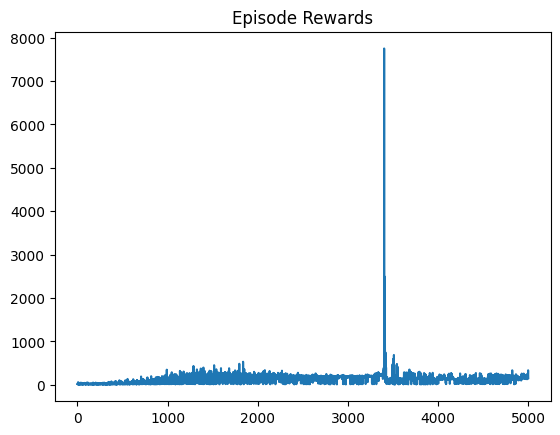

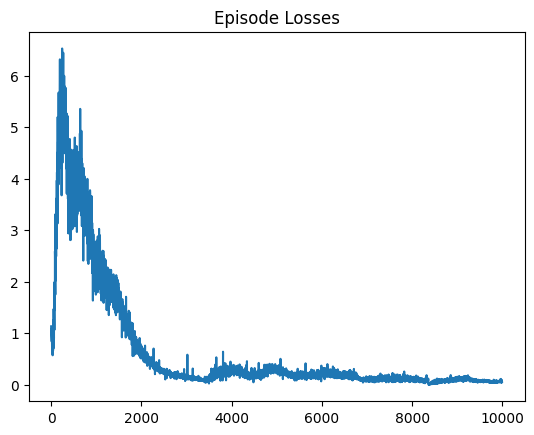

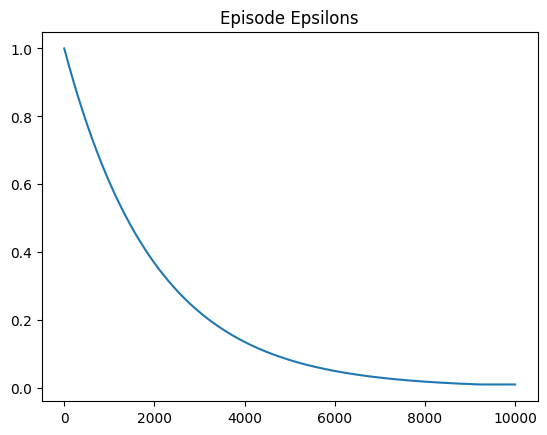

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=episode_rewards)
plt.title("Episode Rewards")
plt.show()

sns.lineplot(data=episode_losses)
plt.title("Episode Losses")
plt.show()

sns.lineplot(data=episode_epsilons)
plt.title("Episode Epsilons")
plt.show()

In [ ]:
test_env = gym.make("CartPole-v1", render_mode="human")

evaluation_episodes = 10
for _ in range(evaluation_episodes):
    state, _ = test_env.reset()
    done, truncated = False, False
    total_reward = 0
    while not done and not truncated:
        state_in = tf.expand_dims(state, axis=0)
        action = tf.argmax(main_model(state_in)[0]).numpy()
        state, _, done, truncated, _ = test_env.step(action)

test_env.close()